In [20]:
import sys
sys.path.append("..\..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import trange
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import auc, roc_curve
from src.data.utils.levenshtein import calculate_levenshtein_distances
import seaborn as sns
from scipy import stats

from src.data.datasets.overlaps import OverlapsDataset

In [21]:
dataset = OverlapsDataset.from_path("..\\..\\datasets\\PlagiNet")

Extracting non-overlapping features: 100%|██████████| 760/760 [00:22<00:00, 33.06it/s]


In [22]:
df = pd.DataFrame(
    np.concatenate([dataset.features, dataset.targets.reshape(-1, 1)], axis=1), 
    columns=dataset.feature_names + ['is_overlapping']
)
df

,levenshtein_distance,match_len1,match_len2,match_ratio1,match_ratio2,note_C,note_C♯,note_D,note_D♯,note_E,...,interval_6,interval_7,interval_8,interval_9,interval_10,interval_lt,interval_gt,interval_to_rest,interval_from_rest,is_overlapping
0,0.235290,-0.506027,-0.508394,-0.562391,-0.563156,-0.525179,-0.721058,-0.441421,-0.668382,-0.912110,...,-0.407332,0.014410,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-1.004430,-1.004430,1.0
1,-1.185390,1.146240,0.846692,1.409168,0.263556,-0.914570,0.333407,-0.587439,-0.668382,-0.510787,...,-0.407332,0.991754,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.347445,-0.347445,1.0
2,-1.181321,2.417214,0.969882,2.598739,2.565198,-0.135788,-0.325633,-1.025490,-0.136766,-0.611117,...,2.455000,-0.474263,1.869871,-0.271666,-0.328564,-0.473907,-0.365269,-1.332923,-1.332923,1.0
3,-1.176717,0.193009,3.864841,-0.083391,2.257328,3.238934,-0.193825,-0.295404,0.394850,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,2.436703,-0.365269,0.966527,0.966527,1.0
4,1.622277,-0.506027,-0.508394,-0.562391,-0.563156,1.681370,-0.721058,-0.295404,-0.668382,0.592852,...,-0.407332,0.991754,0.106268,4.295141,3.043544,-0.473907,2.416274,-1.332923,-1.332923,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.525179,-0.721058,0.580699,-0.668382,-0.410456,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-1.332923,-1.332923,0.0
776,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.914570,-0.589250,-1.025490,-0.668382,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.018952,-0.018952,0.0
777,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.914570,-0.589250,-1.025490,-0.668382,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.018952,-0.018952,0.0
778,-0.032375,-0.506027,-0.508394,-0.562391,-0.563156,-0.914570,0.201599,-1.025490,0.040439,-0.912110,...,-0.407332,-0.962935,-0.397618,-0.271666,-0.328564,-0.473907,-0.365269,-0.018952,-0.018952,0.0


In [23]:
positive_count = int(np.sum(dataset.targets == 1))
negative_count = int(np.sum(dataset.targets == 0))

pos_weight = negative_count / positive_count if positive_count > 0 else 1.0
neg_weight = positive_count / negative_count if negative_count > 0 else 1.0

print(f"neg_weight: {neg_weight}")
print(f"pos_weight: {pos_weight}")

neg_weight: 0.02631578947368421
pos_weight: 38.0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataset.features, dataset.targets, test_size=0.2, random_state=42, stratify=dataset.targets)

In [25]:
classifiers = {
    'Логистическая регрессия': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Линейный дискриминантный анализ': LDA(),
    'Метод опорных векторов': svm.SVC(kernel='poly', class_weight='balanced', probability=True, random_state=42),
    'Дерево решений': DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=42),
    'Случайный лес': RandomForestClassifier(class_weight='balanced', max_depth=1, random_state=42),
    'Градиентный бустинг': GradientBoostingClassifier(max_depth=1, random_state=42)
}

In [26]:
def calculate_metrics(
    X_test: np.ndarray,
    y_test: np.ndarray,
    classifier: BaseEstimator,
    n_bootstrap: int = 1000,
    seed: int = 42
) -> dict[str, dict[str, list[float]]]:
    """Вычисляет precision, recall и auc с доверительными интервалами на разных порогах с помощью стратифицированного бутстрапа.

    :param np.ndarray X_test: Массив признаков
    :param np.ndarray y_test: Массив целевых значений
    :param BaseEstimator classifier: Классификатор
    :param int n_bootstrap: Количество итераций бутстрапа
    :param int seed: Сид для генератора случайных чисел

    :return dict[str, dict[str, list[float]]]: Словарь auc и roc
    """
    rng = np.random.default_rng(seed)
    metrics = {
        "auc": {"mean": None, "lower": None, "upper": None},
        "roc": {"fpr": [], "tpr_mean": [], "tpr_lower": [], "tpr_upper": []}
    }

    fpr_lin = np.linspace(0, 1, 100)
    tpr_boot = []
    aucs = []

    pos_indices = np.where(y_test == 1)[0]
    neg_indices = np.where(y_test == 0)[0]
    
    n_pos = len(pos_indices)
    n_neg = len(neg_indices)
    

    for _ in trange(n_bootstrap, desc="Расчет AUC с доверительными интервалами"):

        boot_pos_indices = rng.choice(pos_indices, size=n_pos, replace=True)
        boot_neg_indices = rng.choice(neg_indices, size=n_neg, replace=True)
        
        boot_indices = np.concatenate([boot_pos_indices, boot_neg_indices])
        
        rng.shuffle(boot_indices)
        
        X_boot = X_test[boot_indices]
        y_boot = y_test[boot_indices]
        
        if len(np.unique(y_boot)) < 2:
            continue
        
        y_pred_proba = classifier.predict_proba(X_boot)[:, 1]
        fpr_i, tpr_i, _ = roc_curve(y_boot, y_pred_proba)
        auc_val = auc(fpr_i, tpr_i)

        aucs.append(auc_val)
        
        interp_tpr = np.interp(fpr_lin, fpr_i, tpr_i)
        interp_tpr[0] = 0.0
        tpr_boot.append(interp_tpr)

    aucs = np.array(aucs)
    metrics["auc"]["mean"] = aucs.mean()
    metrics["auc"]["lower"] = np.percentile(aucs, 2.5)
    metrics["auc"]["upper"] = np.percentile(aucs, 97.5)

    tpr_boot = np.array(tpr_boot)
    metrics["roc"]["fpr"] = fpr_lin
    metrics["roc"]["tpr_mean"] = tpr_boot.mean(axis=0)
    metrics["roc"]["tpr_lower"] = np.percentile(tpr_boot, 2.5, axis=0)
    metrics["roc"]["tpr_upper"] = np.percentile(tpr_boot, 97.5, axis=0)

    return metrics

Расчет AUC с доверительными интервалами: 100%|██████████| 1000/1000 [00:00<00:00, 1454.12it/s]


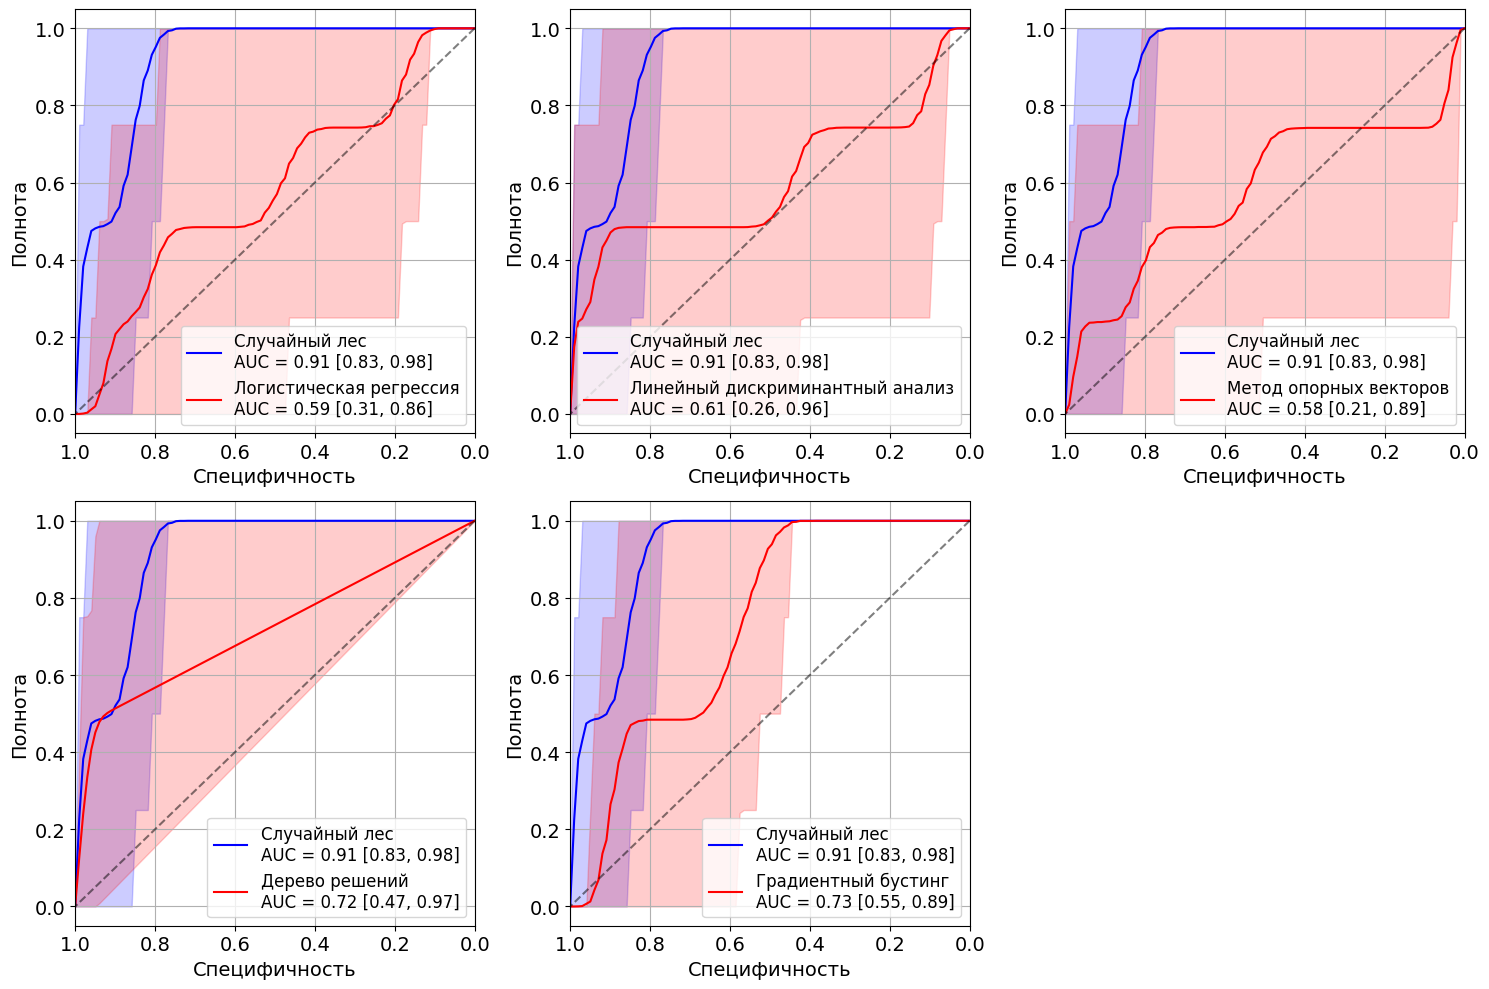

In [27]:
colors = ['blue', 'red']
ci_alpha = 0.2
labels_fontsize=14
legend_fontsize=12
title_fontsize=16
ticks_fontsize=14

rf_classifier = classifiers['Случайный лес']
rf_classifier.fit(X_train, y_train)
rf_metrics = calculate_metrics(X_test, y_test, rf_classifier)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plot_idx = 0
for i, (matcher_title, matcher_class) in enumerate(classifiers.items()):

    if matcher_title != 'Случайный лес':
        ax = axes[plot_idx]
        plot_idx += 1
        
        mean_auc = rf_metrics["auc"]["mean"]
        lower_auc = rf_metrics["auc"]["lower"]
        upper_auc = rf_metrics["auc"]["upper"]
        fpr = rf_metrics["roc"]["fpr"]
        tpr_mean = rf_metrics["roc"]["tpr_mean"]
        tpr_lower = rf_metrics["roc"]["tpr_lower"]
        tpr_upper = rf_metrics["roc"]["tpr_upper"]
        
        ax.plot(1-fpr, tpr_mean, label=f"Случайный лес\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=colors[0])
        ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=colors[0])
        
        matcher_class.fit(X_train, y_train)
        matcher_metrics = calculate_metrics(X_test, y_test, matcher_class)
        
        mean_auc = matcher_metrics["auc"]["mean"]
        lower_auc = matcher_metrics["auc"]["lower"]
        upper_auc = matcher_metrics["auc"]["upper"]
        fpr = matcher_metrics["roc"]["fpr"]
        tpr_mean = matcher_metrics["roc"]["tpr_mean"]
        tpr_lower = matcher_metrics["roc"]["tpr_lower"]
        tpr_upper = matcher_metrics["roc"]["tpr_upper"]
        
        ax.plot(1-fpr, tpr_mean, label=f"{matcher_title}\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=colors[1])
        ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=colors[1])
        
        ax.plot([0, 1], [1, 0], color="black", linestyle="--", alpha=0.5)
        ax.set_xlabel("Специфичность", fontsize=labels_fontsize)
        ax.set_ylabel("Полнота", fontsize=labels_fontsize)
        ax.set_xlim((1, 0))
        ax.legend(loc="lower right", fontsize=legend_fontsize)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

axes[-1].axis('off')
plt.tight_layout()

Расчет AUC с доверительными интервалами: 100%|██████████| 1000/1000 [00:02<00:00, 422.90it/s]


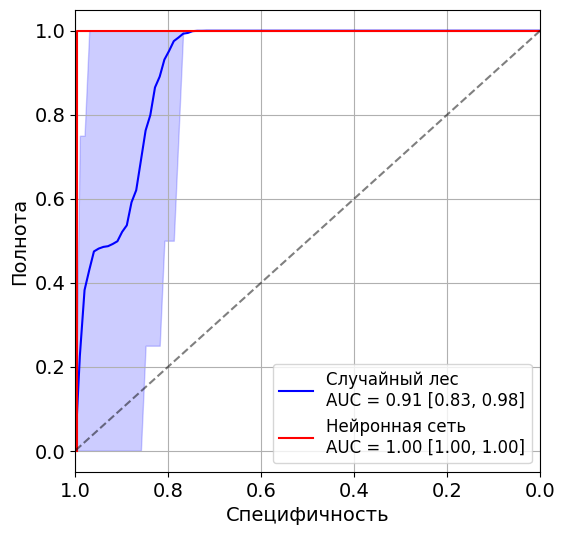

In [28]:
colors = ['blue', 'red']
ci_alpha = 0.2
labels_fontsize=14
legend_fontsize=12
title_fontsize=16
ticks_fontsize=14

rf_classifier = classifiers['Случайный лес']
rf_classifier.fit(X_train, y_train)
rf_metrics = calculate_metrics(X_test, y_test, rf_classifier)

fig, ax = plt.subplots(1,1, figsize=(6, 6))

mean_auc = rf_metrics["auc"]["mean"]
lower_auc = rf_metrics["auc"]["lower"]
upper_auc = rf_metrics["auc"]["upper"]
fpr = rf_metrics["roc"]["fpr"]
tpr_mean = rf_metrics["roc"]["tpr_mean"]
tpr_lower = rf_metrics["roc"]["tpr_lower"]
tpr_upper = rf_metrics["roc"]["tpr_upper"]

ax.plot(1-fpr, tpr_mean, label=f"Случайный лес\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=colors[0])
ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=colors[0])

ax.plot([0.995, 0.995, 0], [0, 1, 1], label=f"Нейронная сеть\nAUC = {1:.2f} [{1:.2f}, {1:.2f}]", color=colors[1])

ax.plot([0, 1], [1, 0], color="black", linestyle="--", alpha=0.5)
ax.set_xlabel("Специфичность", fontsize=labels_fontsize)
ax.set_ylabel("Полнота", fontsize=labels_fontsize)
ax.set_xlim((1, 0))
ax.legend(loc="lower right", fontsize=legend_fontsize)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

Calculating distances: 100%|██████████| 760/760 [00:08<00:00, 87.55it/s] 


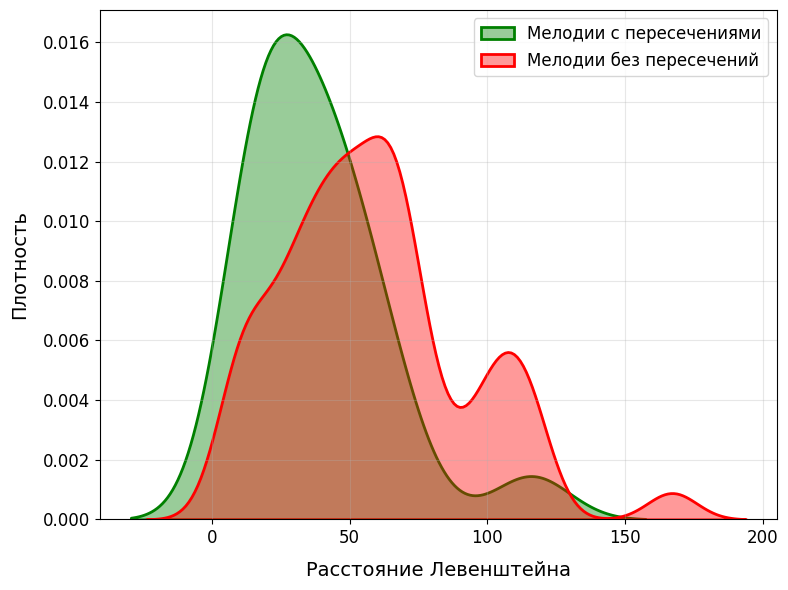

In [29]:
overlapping_distances = calculate_levenshtein_distances(dataset.overlapping_pairs, normalize=False)
non_overlapping_distances = calculate_levenshtein_distances(dataset.non_overlapping_pairs, normalize=False)

all_distances = np.concatenate([overlapping_distances, non_overlapping_distances])
all_labels = np.concatenate([np.ones(len(overlapping_distances)), np.zeros(len(non_overlapping_distances))])

pos_distances = all_distances[all_labels == 1]
neg_distances = all_distances[all_labels == 0]

plt.figure(figsize=(8, 6))

sns.kdeplot(pos_distances, color='green', fill=True, alpha=0.4, label='Мелодии с пересечениями', linewidth=2)
sns.kdeplot(neg_distances, color='red', fill=True, alpha=0.4, label='Мелодии без пересечений', linewidth=2)

plt.xlabel('Расстояние Левенштейна', fontsize=14, labelpad=10)
plt.ylabel('Плотность', fontsize=14, labelpad=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()